- UID: unique identifier ranging from 1 to 10000;
- Tyep: consisting of a letter L, M, or H for low (60% of all products), medium (30%) and high (10%) as product quality variants and a variant-specific serial number;
- Air temperature [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K;
- Process temperature [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K;
- Rotational speed [rpm]: calculated from a power of 2860 W, overlaid with a normally distributed noise;
- Torque [Nm]: torque values are normally distributed around 40 Nm with a standard deviation of 10 Nm and no negative values;
- Tool wear [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process;
- Machine failure: label that indicates, whether the machine has failed in this particular data point for any of the following failure modes are true. The machine failure consists of five independent failure modes:
- tool wear failure (TWF): the tool will be replaced of fail at a randomly selected tool wear time between 200 - 240 mins;
- heat dissipation failure (HDF): heat dissipation causes a process failure, if the difference between air- and process temperature is below 8.6 K and the tools rotational speed is below 1380 rpm;

- power failure (PWF):the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails;

- overstrain failure (OSF): if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain;
- random failures (RNF): each process has a chance of 0,1 % to fail regardless of its process parameters. If at least one of the above failure modes is true, the process fails and the ’machine failure’ label is set to 1. It is therefore not transparent to the machine learning method, which of the failure modes has caused the process to fail.

# Start

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import  matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


In [2]:
df = pd.read_csv('/Users/mikkelpedersen/Desktop/project vs studio/Predictive_maintenece/predictive_maintenance.csv')
df.sample(6).style.set_properties(
    **{
        'background-color': 'White',
        'color': 'Gray',
        'border-color': 'Gray'
    })
df_backup = df.copy()
n = df.shape[0]

In [3]:
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


In [4]:
# check for duplicates
duplicates = df['Product ID'].unique().shape[0] != n
print('Check for duplicates', {duplicates})

data_types = df.info()
print(f'Data types:{data_types}')

df['Tool wear [min]'] = df['Tool wear [min]'].astype(float)
df['Rotational speed [rpm]'] = df['Rotational speed [rpm]'].astype(float)

Check for duplicates {False}
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB
Data types:None


- There is no duplicates in the DataFrame
- The tool wear and rotational speed was different data types then the others so they are converted to float to obtain a consitent DataFrame

In [5]:
df = df.drop(['UDI', 'Product ID'], axis=1)

In [6]:
df.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,M,298.1,308.6,1551.0,42.8,0.0,0,No Failure
1,L,298.2,308.7,1408.0,46.3,3.0,0,No Failure
2,L,298.1,308.5,1498.0,49.4,5.0,0,No Failure
3,L,298.2,308.6,1433.0,39.5,7.0,0,No Failure
4,L,298.2,308.7,1408.0,40.0,9.0,0,No Failure


In [7]:
df.describe()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


The columns UDI and Product ID do not provide any value so they are droppped

In [8]:
df.rename(mapper={'Air temperature [K]' : 'Air temp',
                  'Process temperature [K]' : 'process temp',
                  'Rotational speed [rpm]' : 'rota speed',
                  'Torque [Nm]' : 'torque',
                  'Tool wear [min]' : 'tool wear'}, axis=1, inplace=True)

In [9]:
df['temp dif'] = df['process temp'] - df['Air temp']

In [10]:
def suma(df):
    for col in df[['Type', 'Target', 'Failure Type']]:
        print(df[col].value_counts())
        print('****' * 8)

Text(35.84628395061728, 0.5, 'Amount of type')

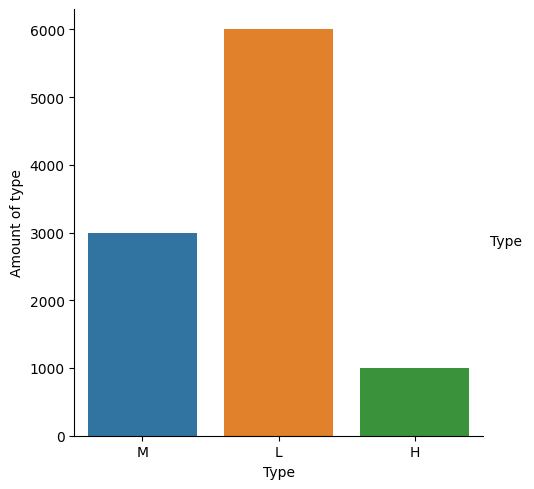

In [11]:
sns.catplot(data=df, x='Type', hue='Type', kind='count')
plt.ylabel('Amount of type')

In [12]:
suma(df)

Type
L    6000
M    2997
H    1003
Name: count, dtype: int64
********************************
Target
0    9661
1     339
Name: count, dtype: int64
********************************
Failure Type
No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: count, dtype: int64
********************************


It is clear that the Type L is the feaute that is orcurring most thourghout the dataset and might mislead

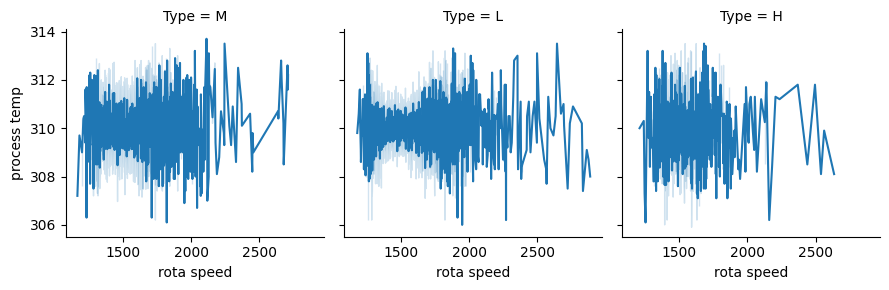

In [13]:
rota_proTemp = sns.FacetGrid(df, col='Type')
rota_proTemp.map(sns.lineplot, 'rota speed', 'process temp')

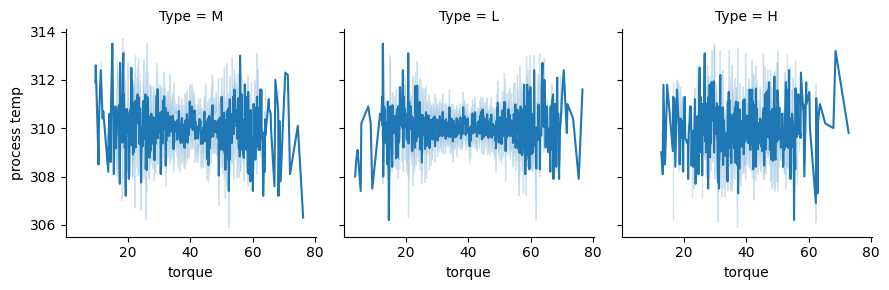

In [14]:
rota_proTemp = sns.FacetGrid(df, col='Type')
rota_proTemp.map(sns.lineplot, 'torque', 'process temp')

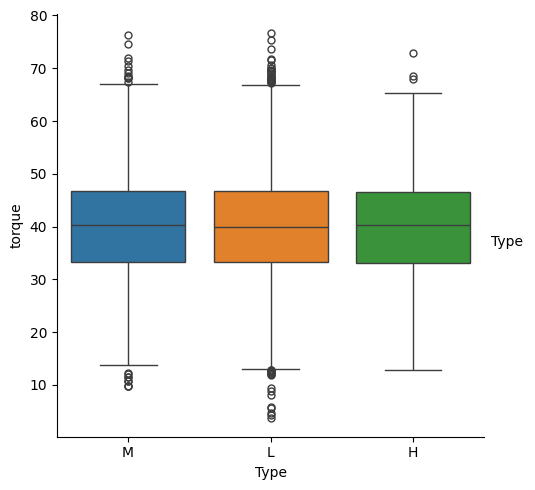

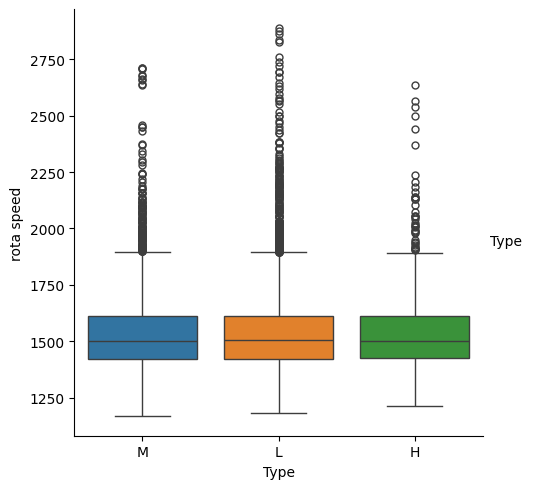

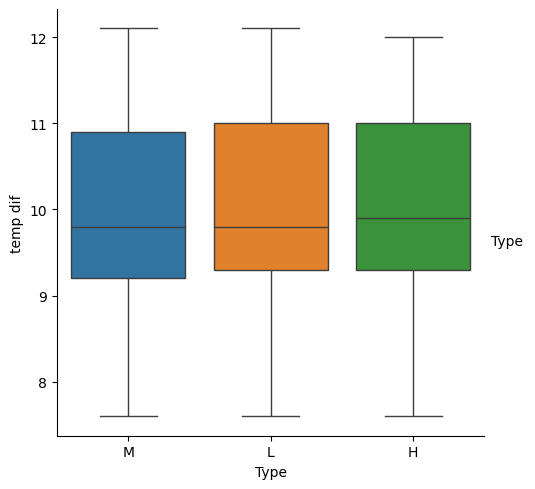

In [15]:
sns.catplot(data=df, x='Type', y='torque', kind='box', hue='Type')
sns.catplot(data=df, x='Type', y='rota speed', kind='box', hue='Type')
sns.catplot(data=df, x='Type', y='temp dif', kind='box', hue='Type')

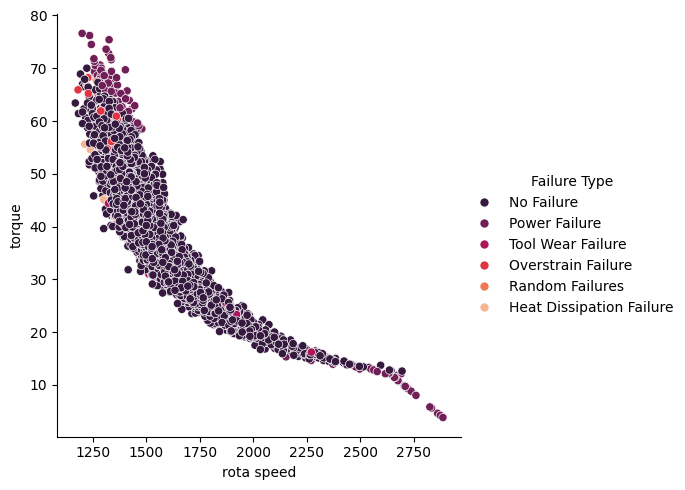

In [16]:
sns.relplot(data=df, x='rota speed', y='torque', hue='Failure Type', palette='rocket')

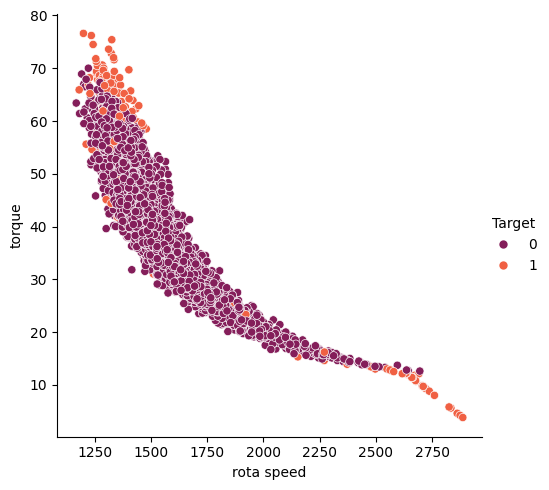

In [17]:
sns.relplot(data=df, x='rota speed', y='torque', hue='Target', palette='rocket')

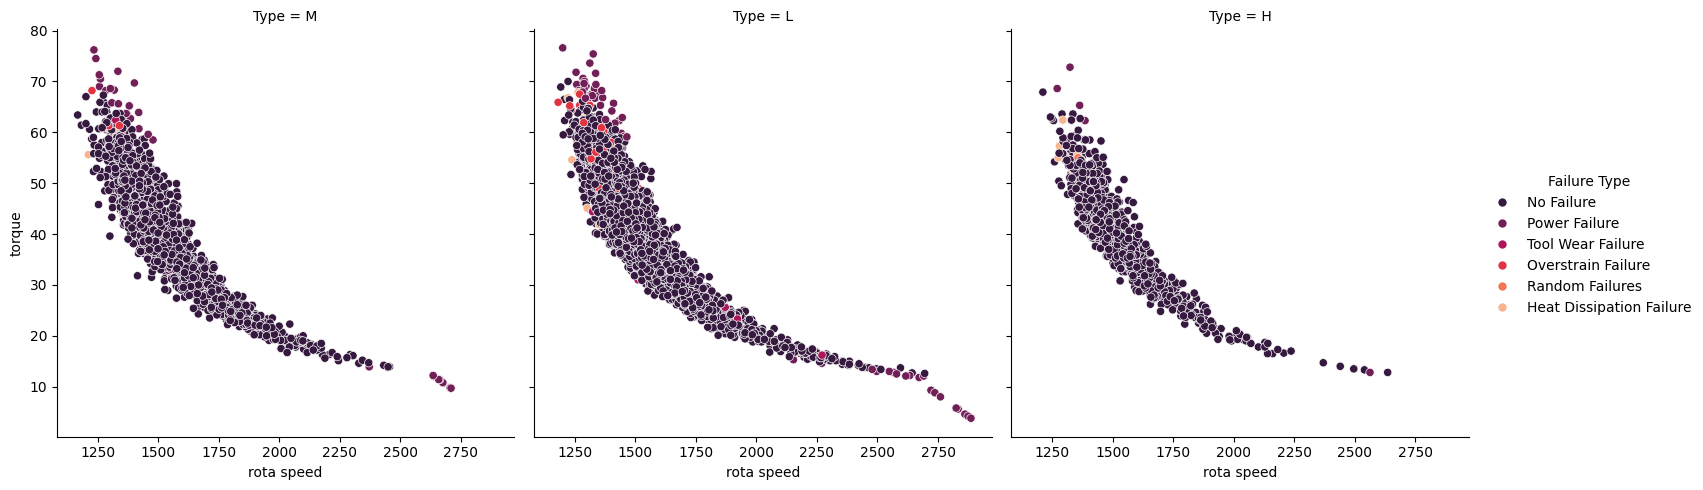

In [18]:
sns.relplot(data=df, x='rota speed', y='torque', hue='Failure Type',col='Type' , palette='rocket')

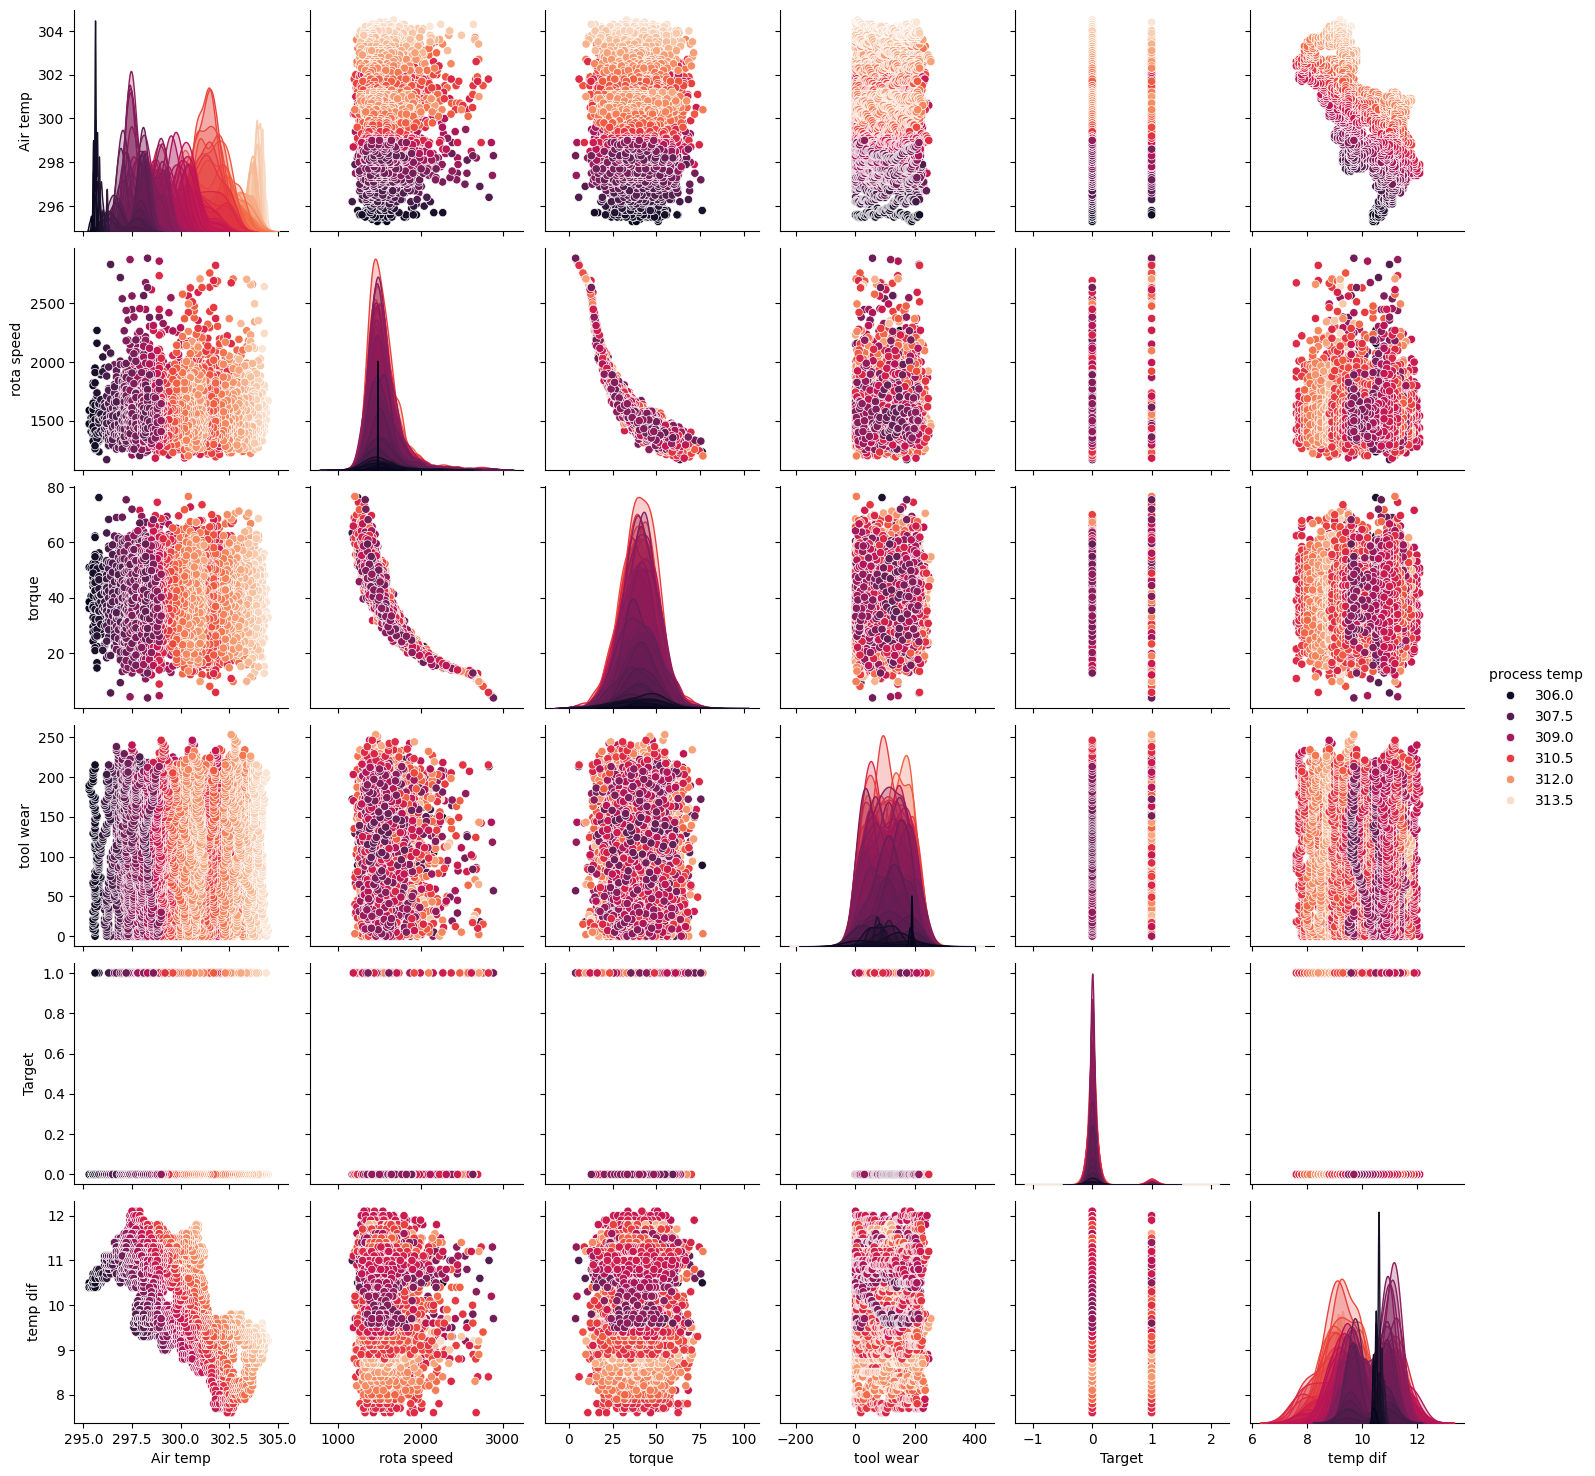

In [19]:
sns.pairplot(df, hue='process temp', palette='rocket')

Failures percentage in data: 3.39


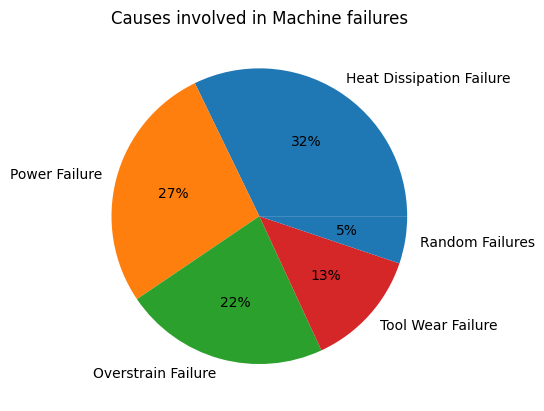

In [27]:
idx_fail = df.loc[df['Failure Type'] != 'No Failure'].index
df_fail = df.loc[idx_fail]
df_fail_percentage = 100*df_fail['Failure Type'].value_counts()/df_fail['Failure Type'].shape[0]
print('Failures percentage in data:',
      round(100*df['Target'].sum()/n,2))
# Pie plot
plt.title('Causes involved in Machine failures')
plt.pie(x=df_fail_percentage.array, labels=df_fail_percentage.index.array,
        colors=sns.color_palette('tab10')[0:4], autopct='%.0f%%')
plt.show()

## Sum up EDA

- The EDA shows clearly that the data is highly distributed towards the the low product quality.
    - The disrtibution is as follows: L6000 M2997 H1003

- The Rotational speed have the highest correlation with the number of failures. 
    - This is because a higher rotational speed means more a higher tempature and wear on the system
    - Futhermore the rotational speed have the highst amount of  outliers compared to other features.


- The amount of failures is 339 distributed over the dataset

- The failure types are as follows:
    - No Failure:                  9652
    - Heat Dissipation Failure:     112
    - Power Failure:                 95
    - Overstrain Failure:            78
    - Tool Wear Failure:             45
    - Random Failures:               18


- For a sub-conclusion it can be deducded that the most common type of failure is "Heat Dissipation Failure" which assumed to be coused by the increase in rotational speed


- We can guess the presence of outliers in Rotational Speed and Torque because the maximum is very different from the third quartile. To make this consideration more concrete we take a closer look at the situation with boxplots, using histograms to understand the distribution.

In [20]:
suma(df)

Type
L    6000
M    2997
H    1003
Name: count, dtype: int64
********************************
Target
0    9661
1     339
Name: count, dtype: int64
********************************
Failure Type
No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: count, dtype: int64
********************************


# Feature selection

In [28]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC

In [36]:
n_working = df['Failure Type'].value_counts()['No Failure']
desired_length = round(n_working/0.8)
spc = round((desired_length-n_working)/4)  #samples per class

# Resampling
balance_cause = {'No Failure':n_working,
                 'Overstrain Failure':spc,
                 'Heat Dissipation Failure':spc,
                 'Power Failure':spc,
                 'Tool Wear Failure':spc}
sm = SMOTENC(categorical_features=[0,7], sampling_strategy=balance_cause, random_state=0)
df_res, y_res = sm.fit_resample(df, df['Failure Type'])

Percentage increment of observations after oversampling: 20.82
SMOTE Resampled Failures percentage: 20.11


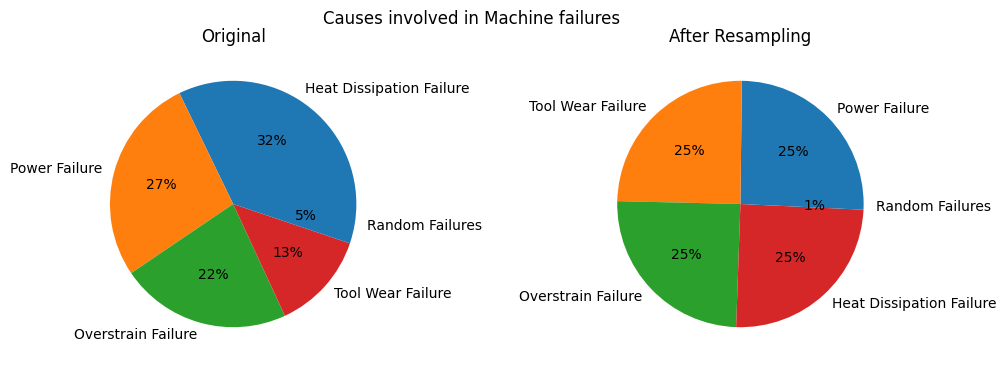

In [39]:
# Portion of df_res where there is a failure and causes percentage
idx_fail_res = df_res.loc[df_res['Failure Type'] != 'No Failure'].index
df_res_fail = df_res.loc[idx_fail_res]
fail_res_percentage = 100*df_res_fail['Failure Type'].value_counts()/df_res_fail.shape[0]

print('Percentage increment of observations after oversampling:',
      round((df_res.shape[0]-df.shape[0])*100/df.shape[0],2))
print('SMOTE Resampled Failures percentage:',
      round(df_res_fail.shape[0]*100/df_res.shape[0],2))

fig, axs = plt.subplots(ncols=2, figsize=(12,4))
fig.suptitle('Causes involved in Machine failures')
axs[0].pie(x=df_fail_percentage.array, labels=df_fail_percentage.index.array,
        colors=sns.color_palette('tab10')[0:4], autopct='%.0f%%')
axs[1].pie(x=fail_res_percentage.array, labels=fail_res_percentage.index.array,
        colors=sns.color_palette('tab10')[0:4], autopct='%.0f%%')
axs[0].title.set_text('Original')
axs[1].title.set_text('After Resampling')
plt.show()

#### Functions for encoding

In [43]:
def cat_encode(data, columns):
    ordinal_encoder = OrdinalEncoder()
    data[columns] = ordinal_encoder.fit_transform(data[columns])
    return data

def lable_encode(data, column_name):
    scaler = LabelEncoder()
    data[column_name] = scaler.fit_transform(data[column_name])
    return data

In [44]:
pre_process_df = df_res.copy()

In [45]:
df = cat_encode(pre_process_df, ['Failure Type', 'Type'])
df = lable_encode(pre_process_df, 'Failure Type')
df

,Type,Air temp,process temp,rota speed,torque,tool wear,Target,Failure Type,temp dif
0,2.0,298.100000,308.600000,1551.000000,42.800000,0.000000,0,1,10.500000
1,1.0,298.200000,308.700000,1408.000000,46.300000,3.000000,0,1,10.500000
2,1.0,298.100000,308.500000,1498.000000,49.400000,5.000000,0,1,10.400000
3,1.0,298.200000,308.600000,1433.000000,39.500000,7.000000,0,1,10.400000
4,1.0,298.200000,308.700000,1408.000000,40.000000,9.000000,0,1,10.500000
...,...,...,...,...,...,...,...,...,...
12077,1.0,301.868728,311.076398,1406.303810,46.522712,207.613558,1,5,9.207669
12078,1.0,301.603064,312.337390,1519.757447,37.796936,211.454468,1,5,10.734326
12079,1.0,301.722627,310.696221,1688.942875,30.433963,217.660369,1,5,8.973594
12080,1.0,299.539127,308.759276,1608.397658,33.261511,228.997871,1,5,9.220149


The 'Failure Type' encoding:

- No Failure = 1 -> 9652
- Heat Dissipation Failure = 0 -> 112
- Power Failure = 3 -> 95
- Overstrain Failure = 2 -> 78
- Tool Wear Failure = 5 -> 45
- Random Failures = 4 -> 18


Product qulitive type
- M = 0
- L = 1
- H = 2

In [46]:
#df_copys1 = cat_encode(df, ['Failure Type', 'Type'])
#df_copys1 = df.copy()
#df_copys1 = lable_encode(df, 'Failure Type')
#df_copys1
#print(df_copys1['Failure Type'].value_counts())

In [47]:
X = pre_process_df.drop(columns=['Failure Type'], axis=1)
y = pre_process_df['Failure Type']

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Models

- DescionTreeClassifier
- RandomForestClassifier
- LogisticRegesion
- SVM

In [49]:
from sklearn import metrics
from sklearn.metrics import classification_report, f1_score, confusion_matrix, recall_score, accuracy_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate, KFold, cross_val_score

In [50]:
def cross_vall_(model, num_folds):
    kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    cross_result = cross_val_score(model, X, y, cv=kf)
    print(f'Cross-Validation Results (Accuracy): {cross_result}')
    print(f'Mean Accuracy: {cross_result.mean()}')

In [51]:
# DecssionTree -> https://www.datacamp.com/tutorial/decision-tree-classification-python
#A decision tree is a flowchart-like tree structure where an internal node represents a feature(or attribute), the branch represents a decision rule, and each leaf node represents the outcome.
#'max_depth': 10, 'min_samples_split': 5

decisiontree = DecisionTreeClassifier()
decisiontree.fit(X_train, y_train)
y_predicted_dec = decisiontree.predict(X_test)

tree_train = round(decisiontree.score(X_train, y_train) * 100, 2)
tree_accuracy = round(accuracy_score(y_predicted_dec, y_test) * 100, 2)

print(f"Train score: {tree_train}%")
print(f"Accuracy on Test Set: {tree_accuracy}%")
print("\033[1m--------------------------------------------------------\033[0m")
print("Classification_Report: \n",classification_report(y_test,y_predicted_dec))
print("\033[1m--------------------------------------------------------\033[0m")

Train score: 100.0%
Accuracy on Test Set: 99.06%
--------------------------------------------------------
Classification_Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       167
           1       1.00      1.00      1.00      2931
           2       0.97      0.99      0.98       201
           3       0.96      0.96      0.96       143
           4       0.00      0.00      0.00         7
           5       0.98      0.97      0.97       176

    accuracy                           0.99      3625
   macro avg       0.82      0.82      0.82      3625
weighted avg       0.99      0.99      0.99      3625

--------------------------------------------------------


In [52]:
#RandomForestClassifier -> https://www.datacamp.com/tutorial/random-forests-classifier-python
#In a random forest classification, multiple decision trees are created using different random subsets of the data and features
# 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100
randforest = RandomForestClassifier(n_estimators=100,random_state=42)
randforest.fit(X_train, y_train)
y_predicted_randforest = randforest.predict(X_test)
randforest.score(X_train, y_train)

randforest_train = round(randforest.score(X_train,y_train)*100, 2)
randforest_accuracy = round(accuracy_score(y_predicted_randforest, y_test )*100, 2)

print(f"Train score: {randforest_train}%")
print(f"Accuracy on Test Set: {randforest_accuracy}%")
print("\033[1m--------------------------------------------------------\033[0m")
print("Classification_Report: \n",classification_report(y_test,y_predicted_randforest))
print("\033[1m--------------------------------------------------------\033[0m")

Train score: 100.0%
Accuracy on Test Set: 99.59%
--------------------------------------------------------
Classification_Report: 
               precision    recall  f1-score   support

           0       1.00      0.99      1.00       167
           1       1.00      1.00      1.00      2931
           2       0.99      1.00      0.99       201
           3       0.97      1.00      0.98       143
           4       0.00      0.00      0.00         7
           5       1.00      0.98      0.99       176

    accuracy                           1.00      3625
   macro avg       0.82      0.83      0.83      3625
weighted avg       0.99      1.00      0.99      3625

--------------------------------------------------------


In [53]:
# Logistic Regression -> https://www.datacamp.com/tutorial/understanding-logistic-regression-python
# Logistic regression describes and estimates the relationship between one dependent binary variable and independent variables.

log_reg = LogisticRegression(max_iter=1500, penalty='l1', C=0.05, solver='liblinear')
log_reg.fit(X_train, y_train)
y_predicted_log_reg = log_reg.predict(X_test)

log_reg_train = round(log_reg.score(X_train, y_train)*100, 2)
log_reg_accuracy = round(accuracy_score(y_test, y_predicted_log_reg)*100, 2)

print(f"Train score: {log_reg_train}%")
print(f"Accuracy on Test Set: {log_reg_accuracy}%")
print("\033[1m--------------------------------------------------------\033[0m")
print("Classification_Report: \n",classification_report(y_test,y_predicted_log_reg))
print("\033[1m--------------------------------------------------------\033[0m")

Train score: 99.11%
Accuracy on Test Set: 99.26%
--------------------------------------------------------
Classification_Report: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       167
           1       1.00      1.00      1.00      2931
           2       0.95      0.99      0.97       201
           3       1.00      0.97      0.98       143
           4       0.00      0.00      0.00         7
           5       0.98      0.95      0.96       176

    accuracy                           0.99      3625
   macro avg       0.82      0.82      0.82      3625
weighted avg       0.99      0.99      0.99      3625

--------------------------------------------------------


In [54]:
#SVM/SVC -> https://www.youtube.com/watch?v=efR1C6CvhmE
#

svc_model = SVC()
svc_model.fit(X_train, y_train)
y_predicted_svc = svc_model.predict(X_test)

svc_model_train = round(svc_model.score(X_train, y_train)*100, 2)
svc_model_accuracy = round(accuracy_score(y_test, y_predicted_svc)*100, 2)


print(f"Train score: {svc_model_train}%")
print(f"Accuracy on Test Set: {svc_model_accuracy}%")
print("\033[1m--------------------------------------------------------\033[0m")
print("Classification_Report: \n",classification_report(y_test,y_predicted_svc))
print("\033[1m--------------------------------------------------------\033[0m")

Train score: 80.97%
Accuracy on Test Set: 82.1%
--------------------------------------------------------
Classification_Report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       167
           1       0.82      1.00      0.90      2931
           2       0.00      0.00      0.00       201
           3       0.96      0.33      0.49       143
           4       0.00      0.00      0.00         7
           5       0.00      0.00      0.00       176

    accuracy                           0.82      3625
   macro avg       0.30      0.22      0.23      3625
weighted avg       0.70      0.82      0.75      3625

--------------------------------------------------------


In [165]:
cross_vall_(svc_model, 10)
cross_vall_(randforest, 10)
cross_vall_(decisiontree, 10)
cross_vall_(log_reg, 10)

Cross-Validation Results (Accuracy): [0.968 0.967 0.968 0.962 0.967 0.959 0.97  0.97  0.964 0.96 ]
Mean Accuracy: 0.9655000000000001
Cross-Validation Results (Accuracy): [0.996 0.992 0.998 0.992 0.998 0.995 0.993 0.997 0.994 0.995]
Mean Accuracy: 0.9949999999999999
Cross-Validation Results (Accuracy): [0.992 0.994 0.996 0.992 0.993 0.994 0.995 0.997 0.993 0.993]
Mean Accuracy: 0.9939
Cross-Validation Results (Accuracy): [0.995 0.992 0.997 0.995 0.997 0.994 0.995 0.996 0.994 0.992]
Mean Accuracy: 0.9946999999999999


In [166]:
from sklearn.model_selection import GridSearchCV

def best_grid_search(model):
    print(f'Best parameters: ', model.best_params_)
    print(f'Best score: ', model.best_score_)

rf_parm_grid = {'n_estimators' : [10, 50, 100, 500], 
                'max_depth': [None, 10, 20],
                'min_samples_split' : [2, 5, 10]}
rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=21),param_grid=rf_parm_grid, cv=5)
rf_grid_search.fit(X_train, y_train)
best_grid_search(rf_grid_search)

dt_parm_grid = {'max_depth': [None, 10, 20],
                'min_samples_split' : [2, 5, 10]}
dt_grid_search = GridSearchCV(DecisionTreeClassifier(random_state=21), param_grid=dt_parm_grid, cv=5)
dt_grid_search.fit(X_train,y_train)
best_grid_search(dt_grid_search)


lr_parm_grid = {'max_iter' : [100, 500, 1000, 1500],
                'C': [0.001, 0.01, 0.1, 1, 10, 100],
                'penalty' : ['l1', 'l2']
                }
lr_grid_search = GridSearchCV(LogisticRegression(random_state=21), lr_parm_grid, cv=5)
lr_grid_search.fit(X_train, y_train)
best_grid_search(lr_grid_search)


svc_parm_grid = {'C': [0.1, 1, 10],
                 'gamma': [0.1, 1, 10],
                 'kernel': ['rbf', 'linear']}
svc_grid_search = GridSearchCV(SVC(random_state=21), svc_parm_grid, cv=5)
svc_grid_search.fit(X_train, y_train)
best_grid_search(svc_grid_search)

Best parameters:  {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best score:  0.9948571428571429
Best parameters:  {'max_depth': 10, 'min_samples_split': 5}
Best score:  0.994
Best parameters:  {'C': 100, 'max_iter': 1500, 'penalty': 'l2'}
Best score:  0.9941428571428572
Best parameters:  {'C': 1, 'gamma': 0.1, 'kernel': 'linear'}
Best score:  0.9957142857142858


In [167]:
best_est_rf = rf_grid_search.best_estimator_
best_est_dt =  dt_grid_search.best_estimator_
best_est_lr =  lr_grid_search.best_estimator_
best_est_svc =  svc_grid_search.best_estimator_

y_pred_randforest = best_est_rf.predict(X_test)
y_pred_decisiontree = best_est_dt.predict(X_test)
y_pred_logreg = best_est_lr.predict(X_test)
y_pred_svc = best_est_svc.predict(X_test)


def print_cm(y_test, ypred):
    acc = accuracy_score(y_test, ypred)
    print('Accuracy: ', acc)
    print('classification_report')
    print(classification_report(y_test, ypred))

In [168]:
print_cm(y_test, y_pred_randforest)
print_cm(y_test, y_pred_decisiontree)


Accuracy:  0.9953333333333333
classification_report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        23
           1       1.00      1.00      1.00      2903
           2       0.84      0.95      0.89        22
           3       0.97      0.94      0.95        31
           4       0.00      0.00      0.00         7
           5       0.92      0.86      0.89        14

    accuracy                           1.00      3000
   macro avg       0.78      0.79      0.79      3000
weighted avg       0.99      1.00      0.99      3000

Accuracy:  0.9933333333333333
classification_report
              precision    recall  f1-score   support

           0       0.88      1.00      0.94        23
           1       1.00      1.00      1.00      2903
           2       0.87      0.91      0.89        22
           3       0.96      0.81      0.88        31
           4       0.00      0.00      0.00         7
           5       0.87     

In [169]:
print_cm(y_test, y_pred_logreg)
print_cm(y_test, y_pred_svc)

Accuracy:  0.9933333333333333
classification_report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        23
           1       0.99      1.00      1.00      2903
           2       0.95      0.95      0.95        22
           3       0.97      0.97      0.97        31
           4       0.00      0.00      0.00         7
           5       0.83      0.36      0.50        14

    accuracy                           0.99      3000
   macro avg       0.78      0.71      0.73      3000
weighted avg       0.99      0.99      0.99      3000

Accuracy:  0.996
classification_report
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        23
           1       1.00      1.00      1.00      2903
           2       0.88      0.95      0.91        22
           3       1.00      0.97      0.98        31
           4       0.00      0.00      0.00         7
           5       0.92      0.86      0.

In [172]:
acc_res = pd.DataFrame({'Model' : ['RandomForest', 'DecisionTree', 'LogisticRegression', 'SVM'],
                       'Acc intial' : [accuracy_score(y_test, y_predicted_randforest), accuracy_score(y_test, y_predicted_dec),accuracy_score(y_test, y_predicted_log_reg), accuracy_score(y_test, y_predicted_svc)],
                       'Acc after GridSearch' : [accuracy_score(y_test, y_pred_randforest), accuracy_score(y_test, y_pred_decisiontree),accuracy_score(y_test, y_pred_logreg), accuracy_score(y_test, y_pred_svc)]})

print(acc_res)

                Model  Acc intial  Acc after GridSearch
0        RandomForest    0.995000              0.995333
1        DecisionTree    0.994667              0.993333
2  LogisticRegression    0.992333              0.993333
3                 SVM    0.968000              0.996000


The 'Failure Type' encoding:

- Heat Dissipation Failure = 0 -> 112
- No Failure = 1 -> 9652
- Overstrain Failure = 2 -> 78
- Power Failure = 3 -> 95
- Random Failures = 4 -> 18
- Tool Wear Failure = 5 -> 45

Product qulitive type
- M = 0
- L = 1
- H = 2

In [187]:
The_Prediction = y_pred_svc
cross_controll = pd.DataFrame({'Actual':y_test, 'Predicted':The_Prediction})


In [204]:
print(cross_controll.sample(20, random_state=None))

      Actual  Predicted
1468       1          1
8555       1          1
4094       1          1
6006       1          1
9459       1          1
8467       1          1
3601       1          1
4194       1          1
4065       1          1
1112       1          1
1982       1          1
8296       1          1
4352       1          1
1928       1          1
2122       1          1
4442       1          1
59         1          1
376        1          1
3921       1          1
7381       1          1
